In [4]:
import numpy as np
import cv2 as cv
import os
from skimage import data, io, filters, measure, feature, exposure

In [5]:
def markCnt(cnt):
    M = cv.moments(cnt)
    if M['m00']>0 :
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        #cv.putText(img_c, str(i), (cx-10, cy+6), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        return [cx,cy]
    else:
        return [0,0]
    
def isEllipse(cnt, area):
    if(len(cnt)<=5):
        return False
    else:
        ellipse = cv.fitEllipse(cnt)
        (x, y), (MA, ma), angle = cv.fitEllipse(cnt)
        A = np.pi * MA * ma/4
        if area < 5:
            return False
        if A/area<1.2:
            return True
        else:
            return False
    
def solidityCircle(cnt, area,sc):
    (x,y),radius = cv.minEnclosingCircle(cnt)
    center = (int(x),int(y))
    solidityCircle = float(area)/(max(radius**2,0.000001) * np.pi)
    return solidityCircle
    
def isCircle(cnt):
    perimeter = cv.arcLength(cnt,True)
    epsilon = 0.02*perimeter
    approx = cv.approxPolyDP(cnt,epsilon,True)
    if len(approx)>5:
        return True
    else:
        return False

def dist(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def groupWalls(angles, latitude):
    angles = sorted(angles)
    first = angles[0]
    tmp = []
    for angle in angles:
        if angle - first > latitude:
            yield tmp
            tmp = []
        tmp.append(angle)
        first = angle
    yield tmp
    
def groupWallsByAngleDistance(circles, latitudeAngle, latitudeDistance):
    res = []
    circles = sorted(circles,key = lambda circle: circle.a)
    while len(circles)>0:
        cands = []
        
        first = circles[0]
        for circle in circles:
            if circle.a - first.a < latitudeAngle:
                cands.append(circle)
                first = circle
        first = cands[0]
        minD = calcMinDist(cands)
        wall = []
        for circle in cands:
            if dist(first.x, first.y, circle.x, circle.y) < minD*latitudeDistance:
                wall.append(circle)
            else:
                continue
        wallOnlyCnt = []
        for circle in wall:
            wallOnlyCnt.append(circle.i)
            index = None
            for z,c2 in enumerate(circles):
                if c2.i == circle.i:
                    index = z
            circles.pop(index)
        res.append(wallOnlyCnt)
    return res

class Circle:
    def __init__(self,i,x,y,a):
        self.i = i
        self.x = x
        self.y = y
        self.thisDistances = {}
        self.Arr =[]
        self.a = a

In [6]:
def calcDistances(circles):
    for c1 in circles:
        tmp = {}
        for c2 in circles:
            if c1.i != c2.i:
                tmp[c2.i] = dist(c1.x,c1.y,c2.x,c2.y)
        c1.Arr = sorted(tmp.items(), key =
             lambda kv:(kv[1], kv[0]))
        c1.thisDistances = tmp
def calcMinDist(circles):
    distArr = []
    for c in circles:
        for k,v in c.thisDistances.items():
            distArr.append([c.i, k, v])
    distArr = sorted(distArr, key = lambda t:t[2])
    minDist = distArr[0][2]
    return minDist

def clearDir(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

colors = [(255,0,0),(0,255,0),(0,0,255),(219, 77, 77),(167, 219, 77),(77, 134, 219),(198, 77, 219),(219, 108, 77),(77, 219, 191),(77, 98, 219),(219, 77, 188),(219, 139, 77),(77, 212, 219),(84, 77, 219),(219, 77, 167),(219, 188, 77),(77, 219, 165),(103, 77, 219),(219, 77, 139),(210, 219, 77),(77, 179, 219),(127, 77, 219),(219, 77, 93)]
def addHoop(c,wall, contours):
    bgr=colors[c-1]
    cv.putText(img_c, str(len(wall)), (10, c*25), cv.FONT_HERSHEY_SIMPLEX, 0.7, tuple(bgr), 2)
    newCounters = []
    for cnt in wall:
        newCounters.extend(contours[cnt])
    rect = cv.minAreaRect(np.array(newCounters))
    box = cv.boxPoints(rect)
    box = np.int0(box)
    cv.drawContours(img_c,[box],0,tuple(bgr),3)


In [7]:

walls_by_angle = [] #liczba oczek na ścianach
latitude = 180*0.05 #tolerancja
latitudeDistance = 5 #tolerancja odleglosc oczek na jednej scianie przemnozona razy minimalna odleglosc
aproxCircle = 0.9 #czy jest okragiem dla funkcji solidityCircle
sets = ['set/0','set/1', 'set/2', 'set/3'] #foldery z obrazami


for index,setDir in enumerate(sets):
    liczbaOczek = 0
    clearDir('result/' + str(index))
    for fileName in os.listdir(setDir):
        
        #wczytanie, przygotowanie obrazu, kontury
        print(fileName,'----------------')
        f = os.path.join(setDir, fileName)
        if os.path.isfile(f) == False:
            continue
        img = cv.imread(f, cv.IMREAD_GRAYSCALE)
        img_c = cv.imread(f)
       
        imgray = cv.GaussianBlur(img, (15,15), 2)

        p_l, p_r = np.percentile(imgray, (0, 60))
        imexp = exposure.rescale_intensity(imgray, in_range=(p_l, p_r))
        
        if setDir == 'set/3':
            imscaled = cv.inRange(imexp, 60, 255)
        else:
            imscaled = cv.inRange(imexp, 90, 255)
                
        ret, thresh = cv.threshold(imscaled, 127, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
       
        contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        angles = []
        circles = []
        for i, cnt in enumerate(contours):
            if i==0:
                continue          
            area = cv.contourArea(cnt)# powierzchnia

            #sprawdzanie czy jest elipsa
            if isEllipse(cnt, area):
                #cv.ellipse(img,cv.fitEllipse(cnt),(0,255,255),2)
                ellipse = cv.fitEllipse(cnt)
                angle = ellipse[2]
                angles.append(angle)
                if area > 40:
                    [cx, cy] = markCnt(cnt)
    
            #sprawdzenie czy jest kolem
            if solidityCircle(cnt, area, aproxCircle)>aproxCircle:
                angle = -1
                angles[-1] = -1

            #dodanie do listy oczek
            if isCircle(cnt) and isEllipse(cnt, area):
                cv.ellipse(img_c,cv.fitEllipse(cnt),(1/3,255,255),2)
                c = Circle(i, cx, cy, angle)
                circles.append(c)
                
        ## PO WYSZUKANIU OCZEK, GRUPOWANIE
        if len(circles)<2:
            print('liczba oczek:',len(circles))
            res = os.path.join('result/' + str(index), fileName)
            addHoop(1,[c.i for c in circles],contours)
            cv.imwrite(res, img_c)
            continue
        calcDistances(circles)

        print('Group by angle')
        tmp = list(groupWalls(angles, latitude))
        c = 1
        for g in tmp:
            print('liczba oczek na scianie', c, ': ', len(g))
            c += 1

        print('Group by angle and distance')
        tmp = list(groupWallsByAngleDistance(list(circles), latitude, latitudeDistance))
        
        for c,wall in enumerate(tmp):
            liczbaOczek+=len(wall)
            print('liczba oczek na scianie', c+1, ': ', len(wall), ', kontury:',wall)
            if len(tmp)<=300:
                addHoop(c+1,wall, contours)
        print('')
        res = os.path.join('result/' + str(index), fileName)
        cv.imwrite(res, img_c)


block ----------------
block ----------------
easy (1).jpg ----------------
Group by angle
liczba oczek na scianie 1 :  3
Group by angle and distance
liczba oczek na scianie 1 :  3 , kontury: [1, 2, 3]

easy (10).jpg ----------------
Group by angle
liczba oczek na scianie 1 :  2
Group by angle and distance
liczba oczek na scianie 1 :  2 , kontury: [1, 2]

easy (2).jpg ----------------
Group by angle
liczba oczek na scianie 1 :  2
Group by angle and distance
liczba oczek na scianie 1 :  2 , kontury: [1, 2]

easy (3).jpg ----------------
Group by angle
liczba oczek na scianie 1 :  5
Group by angle and distance
liczba oczek na scianie 1 :  5 , kontury: [1, 2, 3, 4, 5]

easy (4).jpg ----------------
Group by angle
liczba oczek na scianie 1 :  4
Group by angle and distance
liczba oczek na scianie 1 :  4 , kontury: [1, 2, 3, 4]

easy (5).jpg ----------------
Group by angle
liczba oczek na scianie 1 :  5
Group by angle and distance
liczba oczek na scianie 1 :  5 , kontury: [1, 2, 3, 4, 5]

ea

Group by angle
liczba oczek na scianie 1 :  15
liczba oczek na scianie 2 :  6
liczba oczek na scianie 3 :  1
liczba oczek na scianie 4 :  28
liczba oczek na scianie 5 :  19
liczba oczek na scianie 6 :  2
Group by angle and distance
liczba oczek na scianie 1 :  3 , kontury: [67, 57, 47]
liczba oczek na scianie 2 :  4 , kontury: [25, 34, 26, 15]
liczba oczek na scianie 3 :  3 , kontury: [59, 52, 44]
liczba oczek na scianie 4 :  2 , kontury: [6, 10]
liczba oczek na scianie 5 :  2 , kontury: [19, 9]
liczba oczek na scianie 6 :  1 , kontury: [56]
liczba oczek na scianie 7 :  6 , kontury: [36, 33, 41, 31, 39, 42]
liczba oczek na scianie 8 :  1 , kontury: [1]
liczba oczek na scianie 9 :  4 , kontury: [78, 71, 79, 74]
liczba oczek na scianie 10 :  6 , kontury: [66, 64, 61, 68, 70, 65]
liczba oczek na scianie 11 :  6 , kontury: [72, 69, 73, 77, 76, 75]
liczba oczek na scianie 12 :  6 , kontury: [40, 37, 32, 29, 38, 35]
liczba oczek na scianie 13 :  6 , kontury: [24, 30, 18, 21, 28, 23]
liczba o

D:\mainD\study\toolsTmp\myAnaconda\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


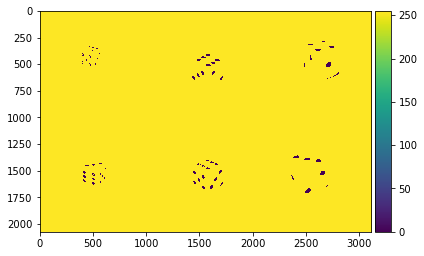

In [8]:
io.imshow(thresh)

In [9]:
img2 = cv.imread('set/3/4.jpg', cv.IMREAD_GRAYSCALE)
        
#imgray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
imgray = cv.GaussianBlur(img2, (15,15), 1)



p_l, p_r = np.percentile(imgray, (0, 60))#(0,2)
imexp = exposure.rescale_intensity(imgray, in_range=(p_l, p_r))

imscaled = cv.inRange(imexp, 90, 255)

ret, thresh = cv.threshold(imscaled, 127, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

io.imshow(imgray)
#io.imshow(thresh)

error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


In [ ]:
io.imshow(thresh)
